# Logistic Regression

## Setup

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch

## Load Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

## Preprocessing

In [3]:
# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

## Theoretical Background

## Multilayer Perceptron From Scratch

Our network will have 2 hidden layers with 6 units each.

- W1: X with shape (num_samples, in_features) will be transformed by W1 (in_features, num_units) to Z1 with shape (num_samples, num_units).
- b1: b1 will be added to the matrix product of X and W1 which will be size (num_samples, num_units), so we will make it shape (num_units).
- W2: A1 with shape (num_samples, num_units) will be transformed by W2 (num_units, num_outpurs) to Z2 with shape (num_samples, num_classes).
- b2: b2 will be added to the matrix product of A1 and W2 which will be size (num_samples, num_classes), so we will make it shape (num_classes).

### Single Batch Iteration

In [4]:
# Create a batch
batch_size = 128
perm = torch.randperm(len(X_train))
X_batch = X_train[perm][:batch_size]
y_batch = y_train[perm][:batch_size]

in_features = X_train.shape[1]
num_units = 256
num_classes = y_train.unique().shape[0]


def relu(x):
    out = torch.maximum(x, torch.zeros(1))
    return out


def softmax(X):
    X_exp = torch.exp(X)
    X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
    return X_softmax


# Define the log-loss
def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss


W1 = nn.Parameter(torch.randn(in_features, num_units) * 0.01)
b1 = nn.Parameter(torch.zeros(num_units))
W2 = nn.Parameter(torch.randn(num_units, num_classes) * 0.01)
b2 = nn.Parameter(torch.zeros(num_classes))

parameters = [W1, b1, W2, b2]
optimizer = SGDScratch(parameters, lr=0.1)

In [5]:
# Zero gradients
optimizer.zero_grad()

# Forward pass
Z1 = X_batch @ W1 + b1
A1 = relu(Z1)
Z2 = A1 @ W2 + b2
y_pred = softmax(Z2)

# Calculate Loss
loss = log_loss(y_pred, y_batch)

# Compute gradients
loss.backward()

# Update parameters
optimizer.step()

In [6]:
get_shape = lambda x: tuple([x.shape[i] for i in range(len(x.shape))])

print("X_batch:", get_shape(X_batch))
print("W1:", get_shape(W1))
print("b1:", get_shape(b1))
print("Z1:", get_shape(Z1))
print("A1:", get_shape(A1))
print("W2:", get_shape(W2))
print("b2:", get_shape(b2))
print("Z2:", get_shape(Z2))
print("y_pred:", get_shape(y_pred))

X_batch: (128, 784)
W1: (784, 256)
b1: (256,)
Z1: (128, 256)
A1: (128, 256)
W2: (256, 10)
b2: (10,)
Z2: (128, 10)
y_pred: (128, 10)


### Define Training Loop and Model

In [7]:
class MLPScratch(nn.Module):
    def __init__(self, in_features, num_classes, num_units):
        super().__init__()
        self.num_classes = num_classes
        self.W1 = nn.Parameter(torch.randn(in_features, num_units) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(num_units))
        self.W2 = nn.Parameter(torch.randn(num_units, num_classes) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(num_classes))

    def relu(self, X):
        out = torch.maximum(X, torch.zeros(1))
        return out

    def softmax(self, X):
        X_exp = torch.exp(X)
        X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
        return X_softmax

    def forward(self, X):
        # Forward pass
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        y_pred = self.softmax(Z2)
        return y_pred

    def parameters(self):
        return [self.W1, self.b1, self.W2, self.b2]

In [8]:
class CrossEntropyScratch(nn.Module):
    def __init__(self, num_classes):
        super(CrossEntropyScratch, self).__init__()
        self.num_classes = num_classes

    def forward(self, y_pred, y_true):
        y_one_hot = nn.functional.one_hot(y_true, self.num_classes)
        loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
        return loss

### Define Training Loop and Model

Epoch 1/20, Training Loss: 1.0427, Validation Loss: 0.4225
Epoch 2/20, Training Loss: 0.3789, Validation Loss: 0.3166
Epoch 3/20, Training Loss: 0.3184, Validation Loss: 0.2834
Epoch 4/20, Training Loss: 0.2852, Validation Loss: 0.2643
Epoch 5/20, Training Loss: 0.2599, Validation Loss: 0.2365
Epoch 6/20, Training Loss: 0.2382, Validation Loss: 0.2172
Epoch 7/20, Training Loss: 0.2196, Validation Loss: 0.2048
Epoch 8/20, Training Loss: 0.2032, Validation Loss: 0.1914
Epoch 9/20, Training Loss: 0.1890, Validation Loss: 0.1776
Epoch 10/20, Training Loss: 0.1776, Validation Loss: 0.1729
Epoch 11/20, Training Loss: 0.1657, Validation Loss: 0.1583
Epoch 12/20, Training Loss: 0.1559, Validation Loss: 0.1519
Epoch 13/20, Training Loss: 0.1472, Validation Loss: 0.1439
Epoch 14/20, Training Loss: 0.1391, Validation Loss: 0.1368
Epoch 15/20, Training Loss: 0.1318, Validation Loss: 0.1306
Epoch 16/20, Training Loss: 0.1252, Validation Loss: 0.1263
Epoch 17/20, Training Loss: 0.1189, Validation Lo

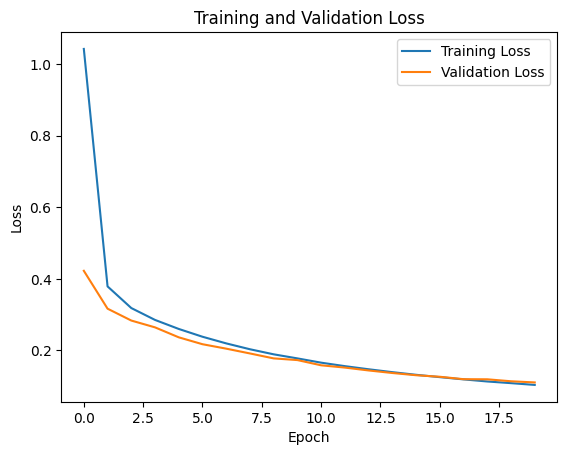

In [9]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_units = 256
num_epochs = 20
learning_rate = 0.1

model = MLPScratch(in_features, num_classes, num_units)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = CrossEntropyScratch(num_classes=num_classes)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of MLP

Epoch 1/10, Training Loss: 2.2132, Validation Loss: 2.0059
Epoch 2/10, Training Loss: 1.8369, Validation Loss: 1.7256
Epoch 3/10, Training Loss: 1.7019, Validation Loss: 1.6716
Epoch 4/10, Training Loss: 1.6690, Validation Loss: 1.6524
Epoch 5/10, Training Loss: 1.6545, Validation Loss: 1.6424
Epoch 6/10, Training Loss: 1.6458, Validation Loss: 1.6359
Epoch 7/10, Training Loss: 1.6399, Validation Loss: 1.6316
Epoch 8/10, Training Loss: 1.6353, Validation Loss: 1.6274
Epoch 9/10, Training Loss: 1.6316, Validation Loss: 1.6243
Epoch 10/10, Training Loss: 1.6102, Validation Loss: 1.5858


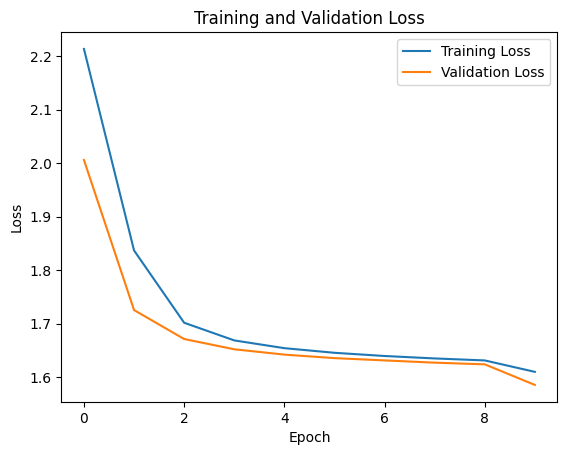

In [10]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, num_units)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(num_units, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.softmax(out)
        return out

model = MLP(input_size=X_train.shape[1], num_classes=y_train.unique().shape[0])

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=10)
